In [2]:
# Import libraries

import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



import tensorflow_datasets as tfds

In [3]:
# Load the data

p_camelyon, p_camelyon_info = tfds.load("patch_camelyon", with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/patch_camelyon/2.0.0.incomplete4C4Z4E/patch_camelyon-test.tfrecord


  0%|          | 0/32768 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/patch_camelyon/2.0.0.incomplete4C4Z4E/patch_camelyon-train.tfrecord


  0%|          | 0/262144 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/patch_camelyon/2.0.0.incomplete4C4Z4E/patch_camelyon-validation.tfrecord


  0%|          | 0/32768 [00:00<?, ? examples/s]

Dataset patch_camelyon downloaded and prepared to /root/tensorflow_datasets/patch_camelyon/2.0.0. Subsequent calls will reuse this data.


In [4]:
# Print information about the data

print(p_camelyon_info)

tfds.core.DatasetInfo(
    name='patch_camelyon',
    version=2.0.0,
    description='The PatchCamelyon benchmark is a new and challenging image classification
dataset. It consists of 327.680 color images (96 x 96px) extracted from
histopathologic scans of lymph node sections. Each image is annoted with a
binary label indicating presence of metastatic tissue. PCam provides a new
benchmark for machine learning models: bigger than CIFAR10, smaller than
Imagenet, trainable on a single GPU.',
    homepage='https://patchcamelyon.grand-challenge.org/',
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(96, 96, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=327680,
    splits={
        'test': 32768,
        'train': 262144,
        'validation': 32768,
    },
    supervised_keys=('image', 'label'),
    citation="""@misc{b_s_veeling_j_linmans_j_winkens_t_cohen_2018_

In [5]:
# Defining a "normalize" function to process the data before feeding it into the deep neural network. 

def normalize(x):
  image, label = x['image'], x['label']
  image = tf.image.convert_image_dtype(image, tf.float32)
  label = tf.one_hot(label, 2, dtype=tf.float32)
  return image, label

In [6]:
# Applying "normalize" function along with others to the data

# Processing the training dataset
train_ds = p_camelyon['train'].map(normalize, num_parallel_calls=8)
train_ds = train_ds.shuffle(1024)
train_ds = train_ds.repeat()
train_ds = train_ds.batch(32)
train_ds = train_ds.prefetch(2)

# Processing validation dataset
validation_ds = p_camelyon['validation'].map(normalize, num_parallel_calls=8)
validation_ds = validation_ds.repeat()
validation_ds = validation_ds.batch(128)
validation_ds = validation_ds.prefetch(2)

#Processing the test dataset
test_ds = p_camelyon['test'].map(normalize, num_parallel_calls=8)
test_ds = test_ds.batch(128)
test_ds = test_ds.prefetch(2)

#Seperating image and label into different variables
train_images, train_labels = next(iter(train_ds))
valid_images, valid_labels = next(iter(validation_ds))
test_images, test_labels  = next(iter(test_ds))


In [7]:
from tensorflow.keras.layers import MaxPool2D

# Building the Convolutonal Network Model

# Setting up the output with the right size
input = Input(shape=(96,96,3))

x = Conv2D(16, (3,3), activation='relu', padding='valid')(input)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(32, (3,3), activation='relu', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(64, (3,3), activation='relu', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(rate=0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(rate=0.2)(x)
output = Dense(2, activation='softmax')(x)

model = Model(inputs=input, outputs = output)
model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['acc'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 94, 94, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 22, 22, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 64)        18496 

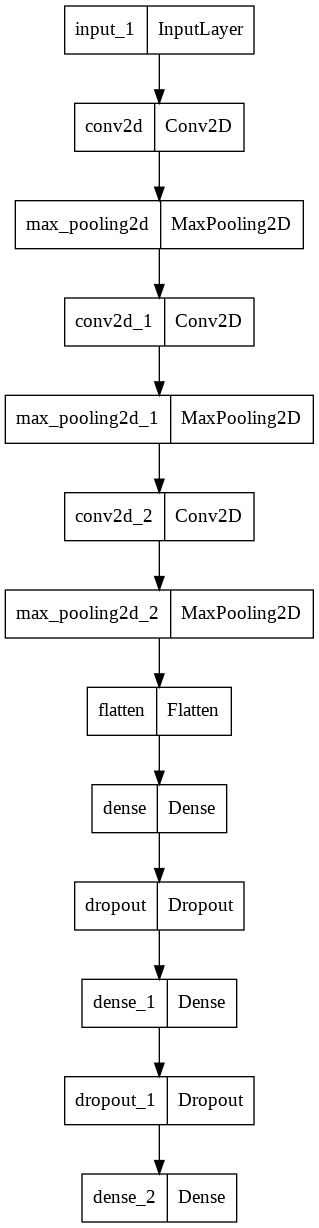

In [8]:
from tensorflow.keras.utils import plot_model

plot_model(model)

In [9]:
import math

batch_size_for_training = 32
batch_size_for_validation = 128
batch_size_for_test = 128

training_size = 262144
validation_size = 32768
test_size =  32768
        

# Calculate steps for training and testing the model
calculate_steps_training = lambda x: int(math.ceil(1. * x / batch_size_for_training))
calculate_steps_validation = lambda x: int(math.ceil(1. * x / batch_size_for_validation))
calculate_steps_test= lambda x: int(math.ceil(1. * x / batch_size_for_test))

steps_per_epoch = calculate_steps_training(training_size) 
validation_steps = calculate_steps_validation(validation_size)
steps = calculate_steps_test(test_size)

print("Training steps: ", steps_per_epoch)
print("Validation steps: ", validation_steps)
print("Testing steps: ", steps)


Training steps:  8192
Validation steps:  256
Testing steps:  256


In [11]:
# Training the model
# steps_per_epoch = (number_of_train_sample/batch_size)

history= model.fit(train_ds, validation_data=validation_ds, epochs = 50, verbose = 1, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)

Epoch 1/50
8192/8192 [==============================] - 95s 11ms/step - loss: 0.1647 - acc: 0.9373 - val_loss: 0.5255 - val_acc: 0.8441
Epoch 2/50
8192/8192 [==============================] - 86s 10ms/step - loss: 0.1509 - acc: 0.9433 - val_loss: 0.5387 - val_acc: 0.8365
Epoch 3/50
8192/8192 [==============================] - 87s 11ms/step - loss: 0.1336 - acc: 0.9503 - val_loss: 0.5030 - val_acc: 0.8320
Epoch 4/50
8192/8192 [==============================] - 108s 13ms/step - loss: 0.1211 - acc: 0.9554 - val_loss: 0.6734 - val_acc: 0.8295
Epoch 5/50
8192/8192 [==============================] - 88s 11ms/step - loss: 0.1079 - acc: 0.9605 - val_loss: 0.7455 - val_acc: 0.8241
Epoch 6/50
8192/8192 [==============================] - 87s 11ms/step - loss: 0.0995 - acc: 0.9638 - val_loss: 0.7707 - val_acc: 0.7991
Epoch 7/50
8192/8192 [==============================] - 88s 11ms/step - loss: 0.0898 - acc: 0.9674 - val_loss: 0.7908 - val_acc: 0.8087
Epoch 8/50
8192/8192 [=========================

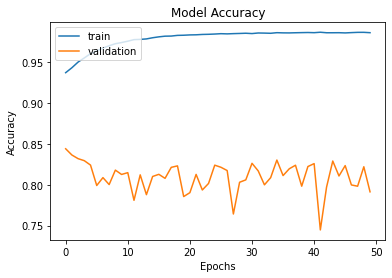

In [12]:
import matplotlib.pyplot as plt

def plot_hist(history):
  plt.plot(history.history["acc"])
  plt.plot(history.history["val_acc"])
  plt.title("Model Accuracy")
  plt.ylabel("Accuracy")
  plt.xlabel("Epochs")
  plt.legend(["train", "validation"], loc="upper left")
  plt.show()

plot_hist(history)

In [23]:
# Testing the model

#prediction = model.predict(test_images)
#evaluation = model.evaluate(test_images, test_labels, verbose=1)
print("Test dataset accuracy is: {0:.4f}".format(model.evaluate(test_ds, steps=steps, verbose=1)[1]))

256/256 [==============================] - 9s 35ms/step - loss: 1.5635 - acc: 0.7492
Test dataset accuracy is: 0.7492
